Практическое задание к курсу
1. Обучите нейронную сеть любой архитектуры которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети.
*вариант для 1) Обучите VAE на fashion_mnist

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Обучим модель для изображений из датасета fashion_mnist

In [6]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
fashion_mnist_pics = np.concatenate([x_train, x_test], axis=0)
fashion_mnist_pics = np.expand_dims(fashion_mnist_pics, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(fashion_mnist_pics, epochs=20, batch_size=128)

4431872/4422102 [==============================] - 0s 0us/step
Epoch 1/20
547/547 [==============================] - 24s 25ms/step - loss: 309.0060 - reconstruction_loss: 304.9465 - kl_loss: 4.0595
Epoch 2/20
547/547 [==============================] - 13s 25ms/step - loss: 269.5726 - reconstruction_loss: 265.9793 - kl_loss: 3.5933
Epoch 3/20
547/547 [==============================] - 13s 24ms/step - loss: 265.8399 - reconstruction_loss: 262.3049 - kl_loss: 3.5350
Epoch 4/20
547/547 [==============================] - 14s 25ms/step - loss: 264.0719 - reconstruction_loss: 260.5504 - kl_loss: 3.5215
Epoch 5/20
547/547 [==============================] - 14s 25ms/step - loss: 262.6232 - reconstruction_loss: 259.0943 - kl_loss: 3.5289
Epoch 6/20
547/547 [==============================] - 13s 24ms/step - loss: 261.7937 - reconstruction_loss: 258.2682 - kl_loss: 3.5255
Epoch 7/20
547/547 [==============================] - 13s 24ms/step - loss: 260.9699 - reconstruction_loss: 257.4392 - kl_loss:

Ошибка постепенно уменьшается, посмотрим на визуализацию

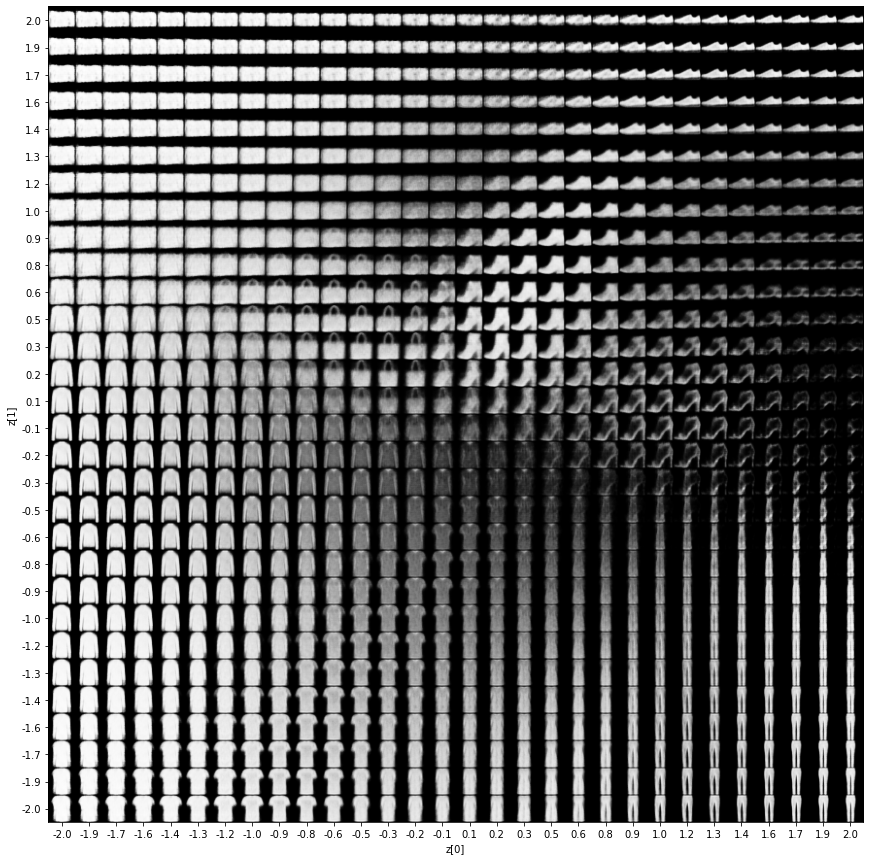

In [7]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((size * n, size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            pic = x_decoded[0].reshape(size, size)
            figure[
                i * size : (i + 1) * size,
                j * size : (j + 1) * size,
            ] = pic

    plt.figure(figsize=(figsize, figsize))
    start_range = size // 2
    end_range = (n - 1) * size + start_range + 1
    pixel_range = np.arange(start_range, end_range, size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

Попробуем усложнить энкодер/декодер

In [8]:
latent_dim = 5

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   640         ['input_3[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 128)    73856       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 6272)         0           ['conv2d_3[0][0]']               
                                                                                            

In [9]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_3 (Dense)             (None, 6272)              37632     
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 128)      147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        577 

Обучим вариационный энкодер

In [10]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(fashion_mnist_pics, epochs=50, batch_size=32)

Epoch 1/50
2188/2188 [==============================] - 41s 18ms/step - loss: 261.8654 - reconstruction_loss: 257.9755 - kl_loss: 3.8899
Epoch 2/50
2188/2188 [==============================] - 39s 18ms/step - loss: 241.6016 - reconstruction_loss: 237.8781 - kl_loss: 3.7236
Epoch 3/50
2188/2188 [==============================] - 39s 18ms/step - loss: 236.7826 - reconstruction_loss: 232.9899 - kl_loss: 3.7927
Epoch 4/50
2188/2188 [==============================] - 39s 18ms/step - loss: 234.8103 - reconstruction_loss: 231.0475 - kl_loss: 3.7628
Epoch 5/50
2188/2188 [==============================] - 40s 18ms/step - loss: 233.6878 - reconstruction_loss: 229.9681 - kl_loss: 3.7197
Epoch 6/50
2188/2188 [==============================] - 39s 18ms/step - loss: 232.8901 - reconstruction_loss: 229.1978 - kl_loss: 3.6923
Epoch 7/50
2188/2188 [==============================] - 39s 18ms/step - loss: 232.2998 - reconstruction_loss: 228.6471 - kl_loss: 3.6526
Epoch 8/50
2188/2188 [===================

Лоссы стабилизировались. Визуализируем полученные результаты.

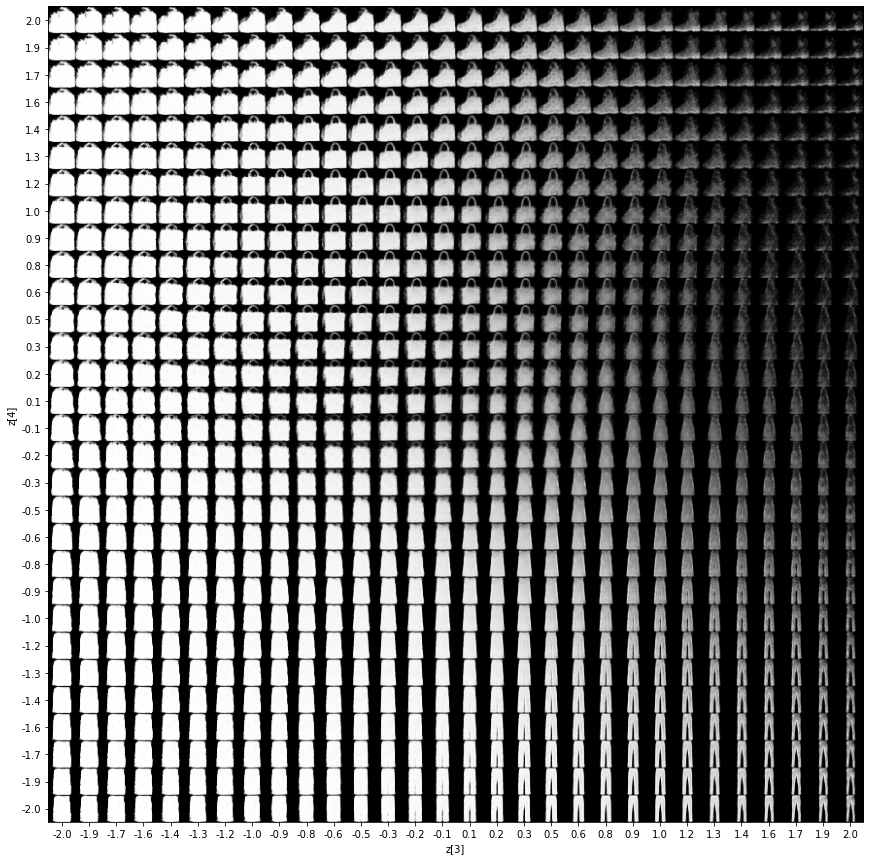

In [11]:
def plot_latent_5D(encoder, decoder):
    n = 30
    size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((size * n, size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[1, 1, 0, xi, yi]])
            x_decoded = decoder.predict(z_sample)
            pic = x_decoded[0].reshape(size, size)
            figure[
                i * size : (i + 1) * size,
                j * size : (j + 1) * size,
            ] = pic

    plt.figure(figsize=(figsize, figsize))
    start_range = size // 2
    end_range = (n - 1) * size + start_range + 1
    pixel_range = np.arange(start_range, end_range, size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[3]")
    plt.ylabel("z[4]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_5D(encoder, decoder)

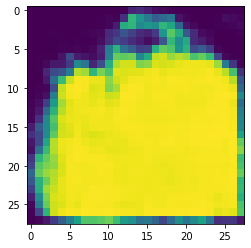

In [19]:
x_decoded = decoder.predict([[1, 1, 0, -1.4, 1.6]])
plt.imshow(x_decoded[0,:,:,0])
plt.show()

2. Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

Нейросети типа GAN сейчас очень популярны и до сих пор активно развиваются в научной литературе, постоянно появлются новые статьи, которые предлагают различные модификации существующих сетей, позволяющие добиться лучших результатов или упростить/ускорить процесс обучения.

Сеть, которая получила название ProgressiveGAN, была представлена уже сравнительно давно - в 2018 году. Статья: https://arxiv.org/pdf/1710.10196.pdf.

Главная проблема, которую она призвана решить, это генерация изображений в высоком разрешении. Авторы, работавшие на момент написания статьи в компании NVIDIA, отмечают, что GAN уже позволял на тот момент добиваться лучших результатов при генерации изображений, в сравнении с VAE и моделями авторегрессии типа PixelCNN. Однако ахиллесовой пятой оставалось разрешение создаваемых картинок.

Поэтому они предложили подход, который подразумевает, что на начальных этапах генератор и дискриминатор работают с небольшим количеством слоев, фактически обрабатывая изображения очень маленького разрешения, концентрируюсь на высокоуровневых признаках. Затем количество и глубина слоев постепенно увеличиваются, что позволяет улавливать все более и более специфичные нюансы изображений. При этом все ранее добавленные слои остаются обучаемыми на протяжении всего процесса. В конечном итоге такая архитектура сети позволила авторам создать изображения с разрешением x. Добавляемые слои вводятся в модель постепенно. На начальном этапе они трактуются в некоторой степени как блоки ResNet и участвуют в обучении с определенным весом.
